# CIFAR-100 with ResNet and Data Augmentation

Author: [https://github.com/ForeverHaibara](https://github.com/ForeverHaibara)

In this experiment we demonstrate how to train a ResNet on CIFAR-100 with data augmentation.

CIFAR-100: [http://www.cs.toronto.edu/~kriz/cifar.html](http://www.cs.toronto.edu/~kriz/cifar.html)

In [16]:
import numpy as np
import paddle 
from matplotlib import pyplot as plt 
from tqdm import tqdm 

In [2]:
#!gzip -dfq /home/aistudio/data/data76994/cifar-100-python.tar.gz
#!tar -xf /home/aistudio/data/data76994/cifar-100-python.tar

In [3]:
def load_data(path):
    import os
    import pickle
    with open(os.path.join(path,'train'), 'rb') as f:
        data_train = pickle.load(f, encoding='latin1')
    with open(os.path.join(path,'test'), 'rb') as f:
        data_test = pickle.load(f, encoding='latin1')
    with open(os.path.join(path,'meta'), 'rb') as f:
        data_meta = pickle.load(f, encoding='latin1')
    return data_train, data_test, data_meta

data_train, data_test, data_meta = load_data('cifar-100-python')
data_train['data'] = data_train['data'].reshape((data_train['data'].shape[0], 3, 32, 32)).transpose((0,2,3,1))
data_test['data'] = data_test['data'].reshape((data_test['data'].shape[0], 3, 32, 32)).transpose((0,2,3,1))

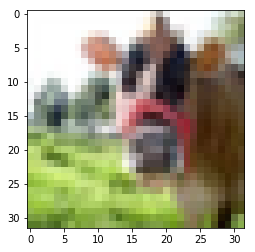

In [17]:
plt.imshow(data_train['data'][0])

## Data Augmentation


We implement the Cutout, Mixup and CutMix.

Reference:

Cutout [https://arxiv.org/abs/1708.04552](https://arxiv.org/abs/1708.04552)

Mixup [https://arxiv.org/abs/1710.09412v2](https://arxiv.org/abs/1710.09412v2)

CutMix [https://arxiv.org/abs/1905.04899](https://arxiv.org/abs/1905.04899)

In [5]:
import numpy as np
import paddle
from tqdm import tqdm 
from PIL import Image 
def augmentate(pics, labels = None, resize = (224, 224), augmentation = False, 
                cut = False, mix = False, rotate = 15):
    '''Simple data augmentator'''
    pics2 = []
    n = pics.shape[0]
    if resize is None:
        resize = pics[0].shape 
    
    if augmentation:
        angles = (np.random.random(n) - .5) * (rotate * 2.)
        flips = np.random.randint(0, 2, n)
        for i in range(n):
            pic = Image.fromarray(pics[i])
            if flips[i]: pic = pic.transpose(Image.FLIP_LEFT_RIGHT)
            pic = pic.resize(resize, Image.ANTIALIAS)
            pic = pic.rotate(angles[i])
            pic = np.array(pic)
            pics2.append(pic)
    
        if cut and not mix:
            # cutout
            cutx = np.random.randint(cut, resize[0], n)
            cuty = np.random.randint(cut, resize[1], n)
            for i in range(n):
                pics2[i][cutx[i]-cut : cutx[i], 
                         cuty[i]-cut : cuty[i], : ] = 0
            labels *= (1. - cut * cut / pics2[0].size)

        elif mix and not cut:
            # mixup
            couple = np.arange(n)
            np.random.shuffle(couple)
            propotion = np.random.random(n)

            # warning: do not modify in-place
            pics3 = [propotion[i] * pics2[couple[i]] + (1 - propotion[i]) * pics2[i] 
                        for i in range(n)]

            # pointer
            pics2 = pics3 

            labels = labels + (labels[couple] - labels) * propotion.reshape((n,1))

        elif cut and mix:
            # cutmix
            couple = np.arange(n)
            np.random.shuffle(couple)
            propotion = np.random.random(n)
            rw = (resize[0] * np.sqrt(propotion)).astype('uint8')
            rh = ((resize[1] / resize[0]) * rw).astype('uint8')

            rx = np.random.randint(65535, size = n) % (resize[0] - rw)
            ry = np.random.randint(65535, size = n) % (resize[1] - rh)

            # warning: do not modify in-place
            pics3 = np.array(pics2)
            for i in range(n):
                pics3[i][rx[i] : rx[i]+rw[i], ry[i] : ry[i]+rh[i]] = \
                    pics2[couple[i]][rx[i] : rx[i]+rw[i], ry[i] : ry[i]+rh[i]] 

            # pointer
            pics2 = pics3

            labels = labels + (labels[couple] - labels) * propotion.reshape((n,1))
            
    else: 
        # no augmentation but resizing
        for i in range(pics.shape[0]):
            pic = Image.fromarray(pics[i])
            pic = pic.resize(resize, Image.ANTIALIAS)
            pic = np.array(pic)
            pics2.append(pic)

    return np.array(pics2), labels
 

def dataloader(data, labels, batch_size = 128, shuffle = True, verbose = True,
                resize = (224,224), augmentation = True, onehot = False,
                cut = False, mix = False, rotate = 15):
    order = np.arange(data.shape[0], dtype = 'int32')
    if shuffle: np.random.shuffle(order)
    labels = np.array(labels)
    __eye = np.eye(np.max(labels) + 1)
    gen = range(data.shape[0] // batch_size)
    if verbose: gen = tqdm(gen)
    for i in gen:
        x = data[order[i * batch_size: i * batch_size + batch_size]]
        l = labels[order[i * batch_size: i * batch_size + batch_size]]

        # extract the onehot encoding
        l = __eye[l]

        # augmentate the data
        x , l = augmentate(x, l, resize = resize, augmentation = augmentation, 
                            cut = cut, mix = mix, rotate = rotate)

        # transpose the dimensions to match (N,C,H,W)
        x = x.transpose((0,3,1,2))
        x = paddle.to_tensor(x, dtype = 'float32') / 255.

        # retrieve the non-onehot encoding if asked
        if not onehot:
            l = labels[order[i * batch_size: i * batch_size + batch_size]]
        yield x , l


def topk(y, labels, top):
    '''compute the number of hits in the top-k prediction'''
    topy = np.argpartition(y, -top, axis=-1)[:,-top:]
    topy -= labels.reshape((labels.shape[0], 1))
    return topy.size - np.count_nonzero(topy)


def test(net, data, batch_size = 100, resize = (224,224), tops = [1,5],
            verbose = False, label = 'fine', augmentation = False):
    accs = [0] * len(tops)
    tops.sort()
    for x, labels in dataloader(data['data'], data[f'{label}_labels'], resize = resize, 
                                  batch_size = batch_size, shuffle = False, verbose = verbose,
                                  augmentation = augmentation):
        y = net(x).numpy()
        labels = np.array(labels)
        for i in range(len(tops)):
            t = topk(y, labels, tops[i])
            accs[i] += topk(y, labels, tops[i])
    return np.array(accs) / data['data'].shape[0]

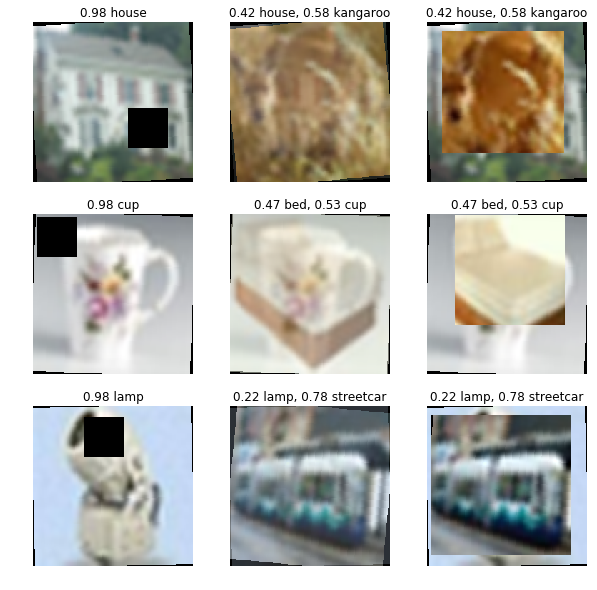

In [29]:
# display some examples of data augmentation
seed = 31415  # change here to try different!

plt.figure(figsize=(10,10))
for i, method in enumerate(((56,False), (0, True), (56, True))):
    np.random.seed(seed)
    for pics in dataloader(data_train['data'], data_train['fine_labels'], verbose = False,
                augmentation=True, onehot = True, cut = method[0], mix = method[1], rotate = 6):
        for j in range(3):
            plt.subplot(3,3,i + j*3 + 1)
            plt.imshow(pics[0][j].transpose((1,2,0)))
            plt.axis('off')
            plt.title(''.join([('%.2f %s, '%(p, data_meta['fine_label_names'][index]) if p > 0 else '')
                            for index, p in enumerate(pics[1][j])])[:-2] )
        break
plt.savefig('work/augmentation.png', bbox_inches='tight')

## Training

As a demo, we use the pretrained network and train around **40 minutes** on GPU.

In [7]:
# use the ResNet-18
net = paddle.vision.models.resnet18(num_classes=100, pretrained=True)

losses = []
accs = []

batch_size = 64      # training batch_size
resize = (224,224)   # resIze images to the given size
cut = 56             # Cutout size
mix = True           # whether or not use Mixup
epochs = 15          # training epochs


optim = paddle.optimizer.Adam(parameters = net.parameters(), learning_rate = 3e-3)

100%|██████████| 69183/69183 [00:01<00:00, 44519.23it/s]
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1441: UserWarning: Skip loading for fc.weight. fc.weight receives a shape [512, 1000], but the expected shape is [512, 100].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1441: UserWarning: Skip loading for fc.bias. fc.bias receives a shape [1000], but the expected shape is [100].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))


In [8]:
from visualdl import LogWriter
writer = LogWriter('work')
n = data_train['data'].shape[0]


for epoch in range(len(accs) + 1, epochs + len(accs) + 1):
    for x , labels in dataloader(data_train['data'], data_train['fine_labels'], batch_size,
                                resize = resize, cut = cut, onehot = True, mix = mix):
        y = net(x) 
        labels = paddle.to_tensor(labels, dtype = 'float32')
        loss = paddle.nn.CrossEntropyLoss(soft_label = True)(y, labels)
        losses.append(loss.item())
        optim.clear_grad()
        loss.backward()
        optim.step()
    
    if epoch in (11, 21): # learning rate decay
        optim.set_lr(optim.get_lr() * .2)
        
    # validate
    accs.append(test(net, data_test, resize = resize))

    # write the log
    for i in range(len(losses) - n // batch_size, len(losses)):
        writer.add_scalar(tag="train/loss", step = i, value = losses[i])  
    writer.add_scalar(tag="valid/top1 acc", step = len(accs), value = accs[-1][0]) 
    writer.add_scalar(tag="valid/top5 acc", step = len(accs), value = accs[-1][1]) 

    # save the model if better
    if accs[-1][0] >= max([i[0] for i in accs]):
        paddle.save(net.state_dict(), 'work/model.pdparams')

writer.close()

  0%|          | 0/781 [00:00<?, ?it/s]/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
100%|██████████| 781/781 [02:29<00:00,  5.24it/s]


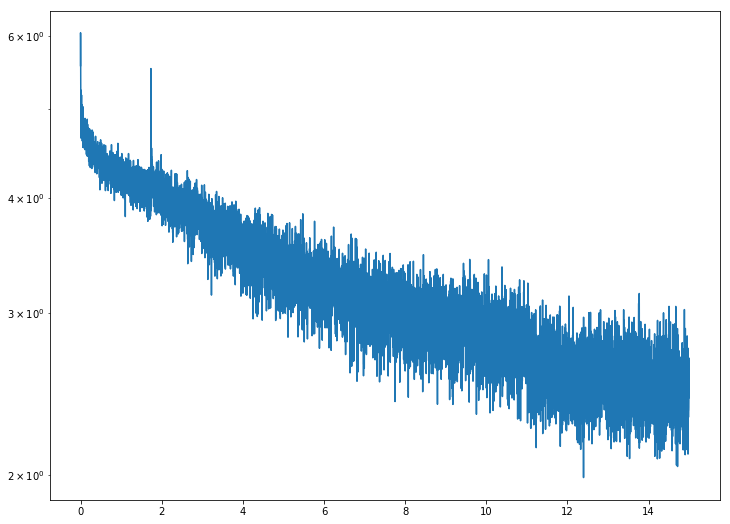

In [9]:
plt.figure(figsize=(12,9))
plt.semilogy(np.linspace(0,len(accs),len(losses)),losses)

In [10]:
print('Train Acc =',test(net, data_train, resize = resize, verbose = True, augmentation = False))

100%|██████████| 500/500 [02:10<00:00,  3.82it/s]

Train Acc = [0.66792 0.9063 ]


Test Acc top1 = [0.085, 0.132, 0.213, 0.262, 0.355, 0.397, 0.435, 0.477, 0.498, 0.512, 0.533, 0.583, 0.595, 0.604, 0.602]
Test Acc top5 = [0.277, 0.391, 0.5, 0.585, 0.684, 0.73, 0.758, 0.785, 0.805, 0.815, 0.832, 0.861, 0.866, 0.869, 0.87]


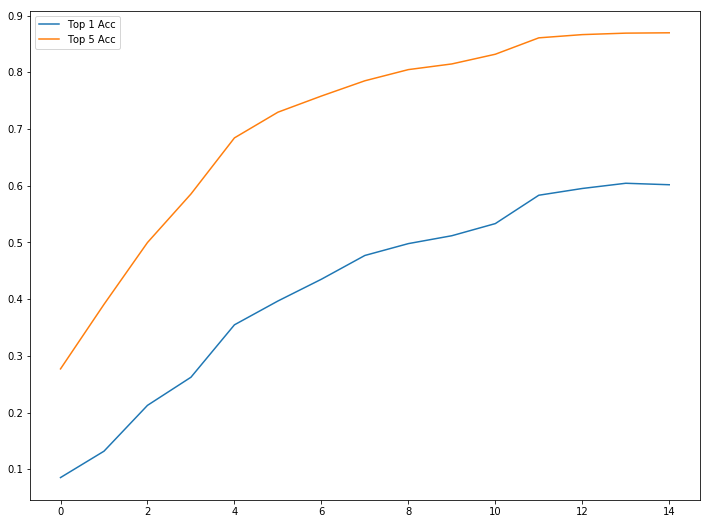

In [11]:
print('Test Acc top1 =',[round(_[0],3) for _ in accs])
print('Test Acc top5 =',[round(_[1],3) for _ in accs])
plt.figure(figsize = (12, 9))
plt.plot([_[0] for _ in accs])
plt.plot([_[1] for _ in accs])
plt.legend(['Top 1 Acc', 'Top 5 Acc'])
plt.show()

## Testing

Test our model.

In [13]:
# load your model
net.set_state_dict(paddle.load('work/model.pdparams'))

Label: kangaroo
Prediction:
kangaroo       0.9251
rabbit         0.0582
otter          0.0025
fox            0.0023
crocodile      0.0019


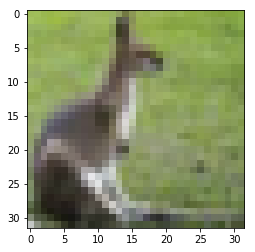

In [28]:
sample_index = 1234    # change here to try different
data_type = data_test  # = data_test or = data_train

# pick up a group (for batch norm)
imgs = data_type['data'][sample_index : sample_index + 64]

# first we shall resize the image to the target size (224, 224)
samples = []
for img in imgs: 
    samples.append(np.array(Image.fromarray(img).resize(resize)))
samples = paddle.to_tensor(np.array(samples).transpose((0,3,1,2)) / 255., dtype = 'float32')

# prediction through network
sample_pred = net(paddle.to_tensor(samples, dtype='float32'))
sample_pred = paddle.nn.Softmax()(sample_pred)[0].numpy()

sample_highest = np.argsort(sample_pred)[-5:][::-1]
sample_pred_names = [data_meta['fine_label_names'][i] for i in sample_highest]
sample_pred_prob  = [sample_pred[i] for i in sample_highest]

print('Label:', data_meta['fine_label_names'][data_type['fine_labels'][sample_index]])
print('Prediction:')
print('\n'.join(['%s%.4f'%(name.ljust(15), prob) for name, prob in zip(sample_pred_names,sample_pred_prob)]))
plt.imshow(imgs[0])